# 인물모드 직접 해 보기

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 전역 변수 및 모델 로딩

### pascalvoc 데이터 라벨 종류

In [2]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [3]:
KNOWN_PIXELLIB_COLORS_RGB = {
    'dog': np.array([128, 0, 64], dtype=np.uint8),
    'person': np.array([128, 128, 192], dtype=np.uint8),
    'sofa': np.array([0, 192, 0], dtype=np.uint8),
}

### 모델 파일 경로 설정 및 다운로드

In [4]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7c9c08033040>)

### 시맨틱 세분화 모델 로드

In [5]:
segment_model = semantic_segmentation()
segment_model.load_pascalvoc_model(model_file)

In [ ]:
def segment_and_blur_background(image_path, target_object_name, target_width=1024, 
                                blur_kernel_size=(13,13), show_steps=False):
    """
    이미지를 로드하고, 지정된 객체를 제외한 배경을 블러 처리합니다.

    Args:
        image_path (str): 처리할 이미지 파일 경로.
        target_object_name (str): 배경에서 분리하여 선명하게 유지할 객체의 이름 (예: 'dog', 'person').
        target_width (int, optional): 이미지 리사이즈 시 목표 너비. Defaults to 1024.
        blur_kernel_size (tuple, optional): 배경 블러에 사용할 커널 크기. Defaults to (13,13).
        show_steps (bool, optional): 중간 처리 과정을 Matplotlib으로 표시할지 여부. Defaults to False.

    Returns:
        numpy.ndarray: 배경이 블러 처리된 최종 이미지 배열 (BGR 형식).
                       오류 발생 시 None 반환.
    """
    # --- 1. 이미지 로드 및 리사이즈 ---
    img_orig = cv2.imread(image_path)
    if img_orig is None:
        print(f"Error: Could not read image file at {image_path}")
        return None

    print(f"\nProcessing image: {image_path}")
    print(f"Original shape: {img_orig.shape}")

    h, w = img_orig.shape[:2]
    # 너비가 target_width보다 클 경우에만 리사이즈
    if w > target_width:
        img_resized = cv2.resize(img_orig, (target_width, int(h * target_width / w)))
        print(f"Resized shape: {img_resized.shape}")
    else:
        img_resized = img_orig.copy() # 리사이즈 필요 없으면 원본 복사
        print("Image width is less than or equal to target_width. No resizing needed.")

    if show_steps:
        plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
        plt.title("Resized Original Image")
        plt.show()

    # --- 2. 시맨틱 세분화 수행 ---
    try:
        segvalues, output_seg = segment_model.segmentAsPascalvoc(image_path)
    except Exception as e:
        print(f"Error during segmentation: {e}")
        return None # 경로로 실패 시 종료

    if show_steps:
        plt.imshow(output_seg) # segmentation 결과는 보통 RGB이므로 변환 불필요
        plt.title("Segmentation Output")
        plt.show()

    # --- 3. 목표 객체 마스크 생성 ---
    print("Detected objects:")
    if 'class_ids' not in segvalues:
         print("Error: Segmentation results do not contain 'class_ids'.")
         return None
    detected_ids = segvalues['class_ids']
    for class_id in detected_ids:
        if 0 <= class_id < len(LABEL_NAMES):
            print(f"- {LABEL_NAMES[class_id]} (ID: {class_id})")
        else:
            print(f"- Unknown ID: {class_id}")

    # 목표 객체 ID 찾기
    try:
        target_id = LABEL_NAMES.index(target_object_name.lower())
    except ValueError:
        print(f"Error: Target object '{target_object_name}' is not a valid label name.")
        print(f"Available labels: {LABEL_NAMES}")
        return None

    # 목표 객체가 실제로 검출되었는지 확인
    if target_id not in detected_ids:
         print(f"Target object '{target_object_name}' (ID: {target_id}) not found in the image segmentation results.")
         # 필요시 여기서 None 반환 가능
         return None

    # --- 목표 객체의 색상(seg_color) 결정 (딕셔너리 조회 방식) ---
    target_name_lower = target_object_name.lower()
    print(f"Looking up segmentation color for '{target_name_lower}' (ID: {target_id})...")

    if target_name_lower in KNOWN_PIXELLIB_COLORS_RGB:
        # 미리 정의된 딕셔너리에서 정확한 색상 가져오기
        seg_color = KNOWN_PIXELLIB_COLORS_RGB[target_name_lower]
        print(f"Using predefined known color for '{target_name_lower}': {seg_color}")
    else:
        # 딕셔너리에 해당 객체의 색상이 정의되지 않은 경우
        print(f"Warning: The exact PixelLib output color for '{target_name_lower}' is not predefined in KNOWN_PIXELLIB_COLORS_RGB.")
        print(f"         Cannot create mask. Please add the correct RGB color for '{target_name_lower}' to the dictionary.")
        # 안전하게 None 반환 (또는 다른 오류 처리)
        return None

    # 색상 맵(output_seg)과 목표 색상(seg_color)을 비교하여 마스크 생성
    # output_seg 타입 확인 (보통 uint8)
    print(f"Comparing output_seg (shape: {output_seg.shape}, dtype: {output_seg.dtype}) with seg_color.")
    # output_seg는 원본 이미지 크기 기준
    seg_map = np.all(output_seg == seg_color, axis=-1) # boolean mask, shape (H, W)

    # 마스크가 비어있는지 확인 (색상이 일치하는 픽셀이 없는 경우)
    if not np.any(seg_map):
         print(f"Warning: The mask for '{target_object_name}' created from color comparison is empty.")
         print("  - Check if the generated colormap correctly represents colors in PixelLib's output_seg.")
         print(f"  - Used target color (from generated map): {seg_color}")
         # 디버깅: output_seg에 있는 실제 색상 확인
         unique_colors = np.unique(output_seg.reshape(-1, 3), axis=0)
         print(f"  - Unique colors found in segmentation output (limit 10):\n{unique_colors[:10]}")
         # 여기서 None을 반환할 수도 있습니다.

    if show_steps:
        print(f"Shape of boolean seg_map (before resize): {seg_map.shape}")
        plt.imshow(seg_map, cmap='gray')
        plt.title(f"Boolean Mask for '{target_object_name}' (Original Size)")
        plt.show()

    # --- 마스크 후처리 및 블러링을 위한 준비 ---
    # boolean 마스크를 uint8 마스크 (0 또는 255)로 변환 - 이것이 블러 처리에 필요
    target_img_mask = seg_map.astype(np.uint8) * 255

    # 마스크를 리사이즈된 원본 이미지 크기(img_resized)에 맞게 조정
    target_img_mask_resized = cv2.resize(target_img_mask, (img_resized.shape[1], img_resized.shape[0]), 
                                         interpolation=cv2.INTER_NEAREST)

    # --- 원본 코드의 시각화 부분 (img_show, color_mask, addWeighted) ---
    if show_steps:
        # 원본 시각화 코드 (리사이즈된 이미지 기준)
        img_show = img_resized.copy()
        # cv2.applyColorMap은 uint8 마스크 필요
        color_mask_vis = cv2.applyColorMap(target_img_mask_resized, cv2.COLORMAP_JET)
        # addWeighted도 리사이즈된 이미지/마스크 기준
        img_show = cv2.addWeighted(img_show, 0.6, color_mask_vis, 0.4, 0.0)
        plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
        plt.title(f"Visualization: Original + Color Mask ('{target_object_name}')")
        plt.show()

        # 최종 블러 처리에 사용될 리사이즈된 마스크 표시
        plt.imshow(target_img_mask_resized, cmap='gray')
        plt.title(f"Resized Mask for '{target_object_name}' (Used for Blurring)")
        plt.show()

    # --- 4. 배경 블러 처리 ---
    # 1. 원본 크기 흑백 마스크를 -> 원본 크기 BGR 컬러 마스크로 변환
    img_mask_color_orig_size = cv2.cvtColor(target_img_mask, cv2.COLOR_GRAY2BGR)
    
    # 2. 리사이즈된 원본 이미지 블러 처리 (함수 초반에 만든 img_resized 사용)
    img_orig_blur = cv2.blur(img_resized, blur_kernel_size)
    
    if show_steps:
        print("Blurred Resized Image:")
        plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
        plt.title("Blurred Resized Image (Input for Step 4 AND)")
        plt.show()

    # 3. 원본 크기였던 BGR 컬러 마스크를 -> 블러된 이미지(img_orig_blur) 크기에 맞게 리사이즈
    #    (개 = [255, 255, 255] 흰색, 배경 = [0, 0, 0] 검은색 / 리사이즈됨)
    print(f"Resizing BGR mask from {img_mask_color_orig_size.shape[:2]} to {img_orig_blur.shape[:2]}")
    # interpolation은 마스크에 안전한 NEAREST를 명시적으로 사용 (원본도 그랬기를 가정)
    img_mask_color_resized = cv2.resize(img_mask_color_orig_size,
                                        (img_orig_blur.shape[1], img_orig_blur.shape[0]),
                                        interpolation=cv2.INTER_NEAREST)

    if show_steps:
        print("Resized BGR Mask (Dog=WHITE):")
        plt.imshow(cv2.cvtColor(img_mask_color_resized, cv2.COLOR_BGR2RGB))
        plt.title("Resized BGR Mask (Dog=WHITE)")
        plt.show()

    # 4. 리사이즈된 BGR 컬러 마스크를 반전하여 배경 마스크 생성
    img_bg_mask = cv2.bitwise_not(img_mask_color_resized)

    if show_steps:
        print("Inverted Resized BGR Mask (Dog=BLACK):")
        plt.imshow(cv2.cvtColor(img_bg_mask, cv2.COLOR_BGR2RGB))
        plt.title("Inverted Resized BGR Mask (Dog=BLACK)")
        plt.show()

    # 5. 블러된 이미지와 (리사이즈된) 배경 마스크를 AND 연산하여 블러된 배경만 추출
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)

    if show_steps:
        print("Blurred Background Only (Result of Step 4 - Snippet 2 method):")
        plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
        plt.title("Blurred Background Only (Result of Step 4)")
        plt.show()
    
    img_mask_color = img_mask_color_resized

    # --- 5. 원본 객체와 블러된 배경 합성 ---
    # np.where 사용: 마스크가 255인 곳(객체)은 원본(리사이즈된) 이미지 값을, 아니면(배경) 블러된 배경 값을 사용
    img_final = np.where(img_mask_color == 255, img_resized, img_bg_blur)

    return img_final


## 크로마키 합성 함수

In [ ]:
def apply_chroma_key(fg_image_path, bg_image_path, target_object_name, 
                     target_width=1024, show_steps=False):
    """
    전경 이미지에서 특정 객체를 분리하여 새로운 배경 이미지 위에 합성합니다.

    Args:
        fg_image_path (str): 전경 이미지 파일 경로 (객체가 있는 이미지).
        bg_image_path (str): 새로운 배경 이미지 파일 경로.
        target_object_name (str): 분리할 객체의 이름 (예: 'dog', 'person').
        target_width (int, optional): 전경 이미지 리사이즈 시 목표 너비. Defaults to 1024.
        show_steps (bool, optional): 중간 처리 과정을 Matplotlib으로 표시할지 여부. Defaults to False.

    Returns:
        numpy.ndarray: 객체가 새로운 배경 위에 합성된 최종 이미지 배열 (BGR 형식).
                       오류 발생 시 None 반환.
    """
    global segment_model, LABEL_NAMES, KNOWN_PIXELLIB_COLORS_RGB # 전역 변수 사용 명시

    # --- 1. 전경 이미지 로드 및 리사이즈 ---
    img_fg = cv2.imread(fg_image_path)
    if img_fg is None:
        print(f"Error: Could not read foreground image file at {fg_image_path}")
        return None

    print(f"\nProcessing foreground image: {fg_image_path}")
    print(f"Foreground original shape: {img_fg.shape}")

    h_fg, w_fg = img_fg.shape[:2]
    # 너비가 target_width보다 클 경우에만 리사이즈
    if w_fg > target_width:
        img_fg_resized = cv2.resize(img_fg, (target_width, int(h_fg * target_width / w_fg)))
        print(f"Foreground resized shape: {img_fg_resized.shape}")
    else:
        img_fg_resized = img_fg.copy() # 리사이즈 필요 없으면 원본 복사
        print("Foreground image width is less than or equal to target_width. No resizing needed.")

    if show_steps:
        plt.imshow(cv2.cvtColor(img_fg_resized, cv2.COLOR_BGR2RGB))
        plt.title("Resized Foreground Image")
        plt.show()

    # --- 2. 배경 이미지 로드 ---
    img_bg = cv2.imread(bg_image_path)
    if img_bg is None:
        print(f"Error: Could not read background image file at {bg_image_path}")
        return None
    print(f"Processing background image: {bg_image_path}")
    print(f"Background original shape: {img_bg.shape}")

    # --- 3. 배경 이미지 리사이즈 ---
    # 배경 이미지 크기를 최종 전경 이미지 크기(img_fg_resized)에 맞춤
    target_h, target_w = img_fg_resized.shape[:2]
    img_bg_resized = cv2.resize(img_bg, (target_w, target_h))
    print(f"Background resized shape: {img_bg_resized.shape}")

    if show_steps:
        plt.imshow(cv2.cvtColor(img_bg_resized, cv2.COLOR_BGR2RGB))
        plt.title("Resized Background Image")
        plt.show()

    # --- 4. 전경 이미지 세분화 수행 ---
    # PixelLib은 원본 경로를 사용하는 것이 안정적일 수 있음
    try:
        segvalues, output_seg = segment_model.segmentAsPascalvoc(fg_image_path)
        print(f"Segmentation output map shape: {output_seg.shape}")
    except Exception as e:
        print(f"Error during segmentation: {e}")
        return None
    if show_steps:
        plt.imshow(output_seg) # RGB 결과
        plt.title("Segmentation Output Color Map (Foreground)")
        plt.show()

    # --- 5. 목표 객체 마스크 생성 (전경 이미지 기준) ---
    # 세분화 결과에서 필요한 정보 확인
    if 'class_ids' not in segvalues:
         print("Error: Segmentation results do not contain 'class_ids'.")
         return None
    detected_ids = segvalues['class_ids']
    print("Detected objects in foreground:")
    for class_id in detected_ids:
        if 0 <= class_id < len(LABEL_NAMES): print(f"- {LABEL_NAMES[class_id]} (ID: {class_id})")
        else: print(f"- Unknown ID: {class_id}")

    # 목표 객체 ID 찾기
    try:
        target_id = LABEL_NAMES.index(target_object_name.lower())
    except ValueError:
        print(f"Error: Target object '{target_object_name}' is not a valid label name.")
        return None

    # 목표 객체가 실제로 검출되었는지 확인
    if target_id not in detected_ids:
         print(f"Target object '{target_object_name}' (ID: {target_id}) not found in the foreground image.")
         return None

    # 목표 객체의 색상 찾기 (정의된 딕셔너리 사용)
    target_name_lower = target_object_name.lower()
    if target_name_lower in KNOWN_PIXELLIB_COLORS_RGB:
        seg_color = KNOWN_PIXELLIB_COLORS_RGB[target_name_lower]
        print(f"Using predefined color for '{target_name_lower}': {seg_color}")
    else:
        print(f"Warning: Color for '{target_name_lower}' not predefined in KNOWN_PIXELLIB_COLORS_RGB.")
        return None

    # 색상 비교로 원본 크기 마스크 생성
    seg_map = np.all(output_seg == seg_color, axis=-1) # boolean mask
    target_img_mask = seg_map.astype(np.uint8) * 255 # 0/255 mask, original size

    # 마스크가 비어있는지 확인
    if not np.any(target_img_mask):
         print(f"Warning: The mask for '{target_object_name}' created from color comparison is empty.")
         return None # 마스크 없으면 진행 불가

    # 마스크를 최종 전경 이미지 크기(img_fg_resized)에 맞게 리사이즈
    target_mask_resized = cv2.resize(target_img_mask, (target_w, target_h), interpolation=cv2.INTER_NEAREST)
    # target_mask_resized: 객체=255(흰색), 배경=0(검정)

    if show_steps:
        plt.imshow(target_mask_resized, cmap='gray')
        plt.title(f"Resized Mask for '{target_object_name}' (Object=White)")
        plt.show()

    # --- 6. 합성용 마스크 준비 ---
    # 리사이즈된 마스크를 3채널 BGR로 변환 (객체=흰색)
    fg_mask_color = cv2.cvtColor(target_mask_resized, cv2.COLOR_GRAY2BGR)
    # 반전 마스크 생성 (배경=흰색, 객체=검정)
    bg_mask_color = cv2.bitwise_not(fg_mask_color)

    # --- 7. 전경 객체 분리 ---
    # 선명한 전경 이미지(img_fg_resized)와 객체 마스크(fg_mask_color)를 AND 연산
    # 결과: 객체 부분만 선명하게 남고 배경은 검정색
    img_fg_isolated = cv2.bitwise_and(img_fg_resized, fg_mask_color)

    if show_steps:
        plt.imshow(cv2.cvtColor(img_fg_isolated, cv2.COLOR_BGR2RGB))
        plt.title("Isolated Foreground Object")
        plt.show()

    # --- 8. 새 배경에서 객체 영역 제거 ---
    # 리사이즈된 새 배경 이미지(img_bg_resized)와 배경 마스크(bg_mask_color)를 AND 연산
    # 결과: 배경 부분만 남고 객체가 들어갈 자리는 검정색
    img_bg_prepared = cv2.bitwise_and(img_bg_resized, bg_mask_color)

    if show_steps:
        plt.imshow(cv2.cvtColor(img_bg_prepared, cv2.COLOR_BGR2RGB))
        plt.title("Prepared Background Area")
        plt.show()

    # --- 9. 최종 합성 ---
    # 분리된 전경 객체와 준비된 배경을 더함
    img_final = cv2.add(img_fg_isolated, img_bg_prepared)
    print(f"Finished chroma key processing for '{target_object_name}'.")

    # --- 10. 결과 반환 ---
    return img_final

## 배경 블러 함수 사용 예제

In [7]:
image_paths = [
    os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpg',
    os.getenv('HOME')+'/aiffel/human_segmentation/images/person.png', # 다른 이미지 경로 추가
    os.getenv('HOME')+'/aiffel/human_segmentation/images/furnitures.png', # 또 다른 이미지 경로 추가
]

# 결과 이미지들을 저장할 리스트
result_images = {}


Processing image: /aiffel/aiffel/human_segmentation/images/dog.jpg
Original shape: (3843, 5124, 3)
Resized shape: (768, 1024, 3)
Detected objects:
- background (ID: 0)
- dog (ID: 12)
- person (ID: 15)
- pottedplant (ID: 16)
Looking up segmentation color for 'dog' (ID: 12)...
Using predefined known color for 'dog': [128   0  64]
Comparing output_seg (shape: (3843, 5124, 3), dtype: uint8) with seg_color.
Resizing BGR mask from (3843, 5124) to (768, 1024)

Processing image: /aiffel/aiffel/human_segmentation/images/person.png
Original shape: (640, 513, 3)
Image width is less than or equal to target_width. No resizing needed.
Detected objects:
- background (ID: 0)
- person (ID: 15)
- tv (ID: 20)
Looking up segmentation color for 'person' (ID: 15)...
Using predefined known color for 'person': [128 128 192]
Comparing output_seg (shape: (640, 513, 3), dtype: uint8) with seg_color.
Resizing BGR mask from (640, 513) to (640, 513)

Processing image: /aiffel/aiffel/human_segmentation/images/furni

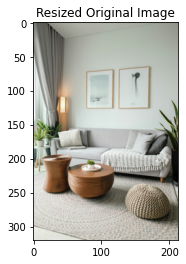

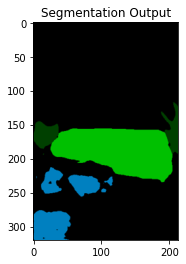

Detected objects:
- background (ID: 0)
- diningtable (ID: 11)
- pottedplant (ID: 16)
- sofa (ID: 18)
Looking up segmentation color for 'sofa' (ID: 18)...
Using predefined known color for 'sofa': [  0 192   0]
Comparing output_seg (shape: (320, 213, 3), dtype: uint8) with seg_color.
Shape of boolean seg_map (before resize): (320, 213)


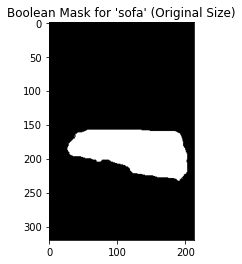

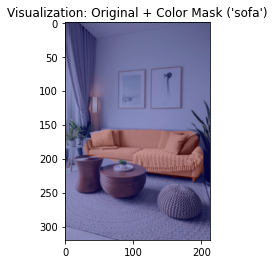

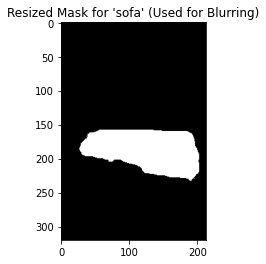

Blurred Resized Image:


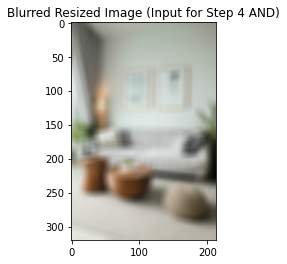

Resizing BGR mask from (320, 213) to (320, 213)
Resized BGR Mask (Dog=WHITE):


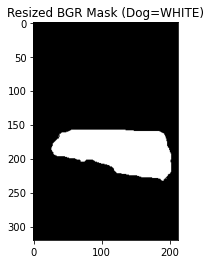

Inverted Resized BGR Mask (Dog=BLACK):


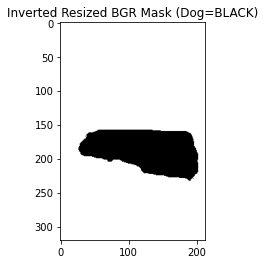

Blurred Background Only (Result of Step 4 - Snippet 2 method):


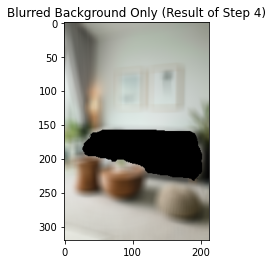

In [ ]:
# 첫 번째 이미지: 'dog'를 대상으로 처리 (중간 과정 미표시)
dog_image_path = image_paths[0]
if os.path.exists(dog_image_path):
    result_dog = segment_and_blur_background(dog_image_path, target_object_name='dog')
    if result_dog is not None:
        result_images['dog'] = result_dog
else:
    print(f"Warning: Image file not found at {dog_image_path}")

# 두 번째 이미지: 'person'을 대상으로 처리 (중간 과정 미표시)
if len(image_paths) > 1:
    person_image_path = image_paths[1]
    if os.path.exists(person_image_path):
        result_person = segment_and_blur_background(person_image_path, target_object_name='person', 
                                                    blur_kernel_size=(13,13)) # 블러 강도 조절 가능
        if result_person is not None:
            result_images['person'] = result_person
    else:
        print(f"Warning: Image file not found at {person_image_path}")

# 세 번째 이미지: 'sofa'를 대상으로 처리 (중간 과정 표시)
if len(image_paths) > 1:
    sofa_image_path = image_paths[2]
    if os.path.exists(sofa_image_path):
        result_sofa = segment_and_blur_background(sofa_image_path, target_object_name='sofa', show_steps=True, 
                                                  blur_kernel_size=(13,13)) # 블러 강도 조절 가능
        if result_sofa is not None:
            result_images['sofa'] = result_sofa
    else:
        print(f"Warning: Image file not found at {sofa_image_path}")


--- Final Results ---


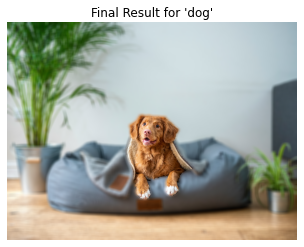

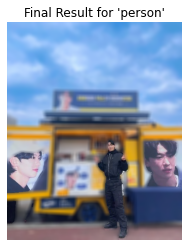

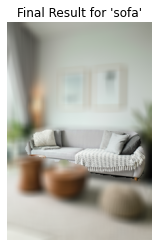

In [9]:
print("\n--- Final Results ---")
for name, img in result_images.items():
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Final Result for '{name}'")
    plt.axis('off') # 축 숨기기
    plt.show()

## 크로마키 함수 사용 예제

In [12]:
fg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.jpg'
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/furnitures.png'
target = 'dog'


--- Applying Chroma Key ---
Foreground: /aiffel/aiffel/human_segmentation/images/dog.jpg
Background: /aiffel/aiffel/human_segmentation/images/furnitures.png
Target Object: dog

Processing foreground image: /aiffel/aiffel/human_segmentation/images/dog.jpg
Foreground original shape: (3843, 5124, 3)
Foreground resized shape: (768, 1024, 3)


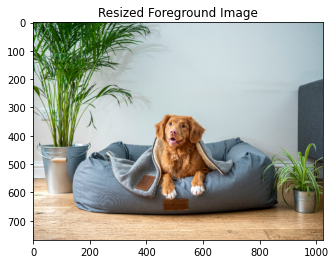

Processing background image: /aiffel/aiffel/human_segmentation/images/furnitures.png
Background original shape: (320, 213, 3)
Background resized shape: (768, 1024, 3)


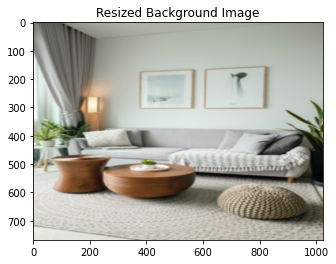

Segmentation output map shape: (3843, 5124, 3)


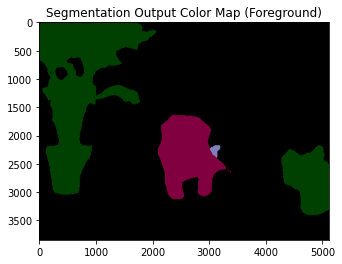

Detected objects in foreground:
- background (ID: 0)
- dog (ID: 12)
- person (ID: 15)
- pottedplant (ID: 16)
Using predefined color for 'dog': [128   0  64]


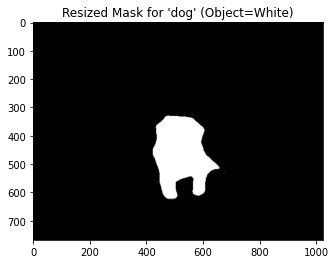

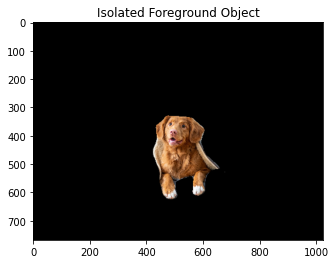

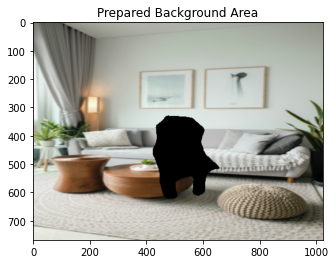

Finished chroma key processing for 'dog'.

--- Chroma Key Final Result ---


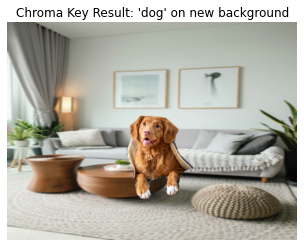

In [13]:
# 배경 이미지 파일이 있는지 확인하고 없으면 생성 (테스트용)
if not os.path.exists(bg_path):
    print(f"Creating a dummy background image at: {bg_path}")
    # 임시로 파란색 배경 이미지 생성 (실제로는 원하는 이미지 사용)
    dummy_bg = np.zeros((720, 1280, 3), dtype=np.uint8)
    dummy_bg[:, :] = [255, 100, 0] # 파란색 배경 (BGR 순서)
    cv2.imwrite(bg_path, dummy_bg)

if os.path.exists(fg_path) and os.path.exists(bg_path):
    print(f"\n--- Applying Chroma Key ---")
    print(f"Foreground: {fg_path}")
    print(f"Background: {bg_path}")
    print(f"Target Object: {target}")

    # 함수 호출
    chroma_result = apply_chroma_key(fg_path, bg_path, target, show_steps=True)

    # 결과 표시
    if chroma_result is not None:
        print("\n--- Chroma Key Final Result ---")
        plt.imshow(cv2.cvtColor(chroma_result, cv2.COLOR_BGR2RGB))
        plt.title(f"Chroma Key Result: '{target}' on new background")
        plt.axis('off')
        plt.show()

        # 결과 이미지 저장 (선택 사항)
        # output_chroma_filename = os.getenv('HOME')+'/aiffel/human_segmentation/images/chroma_result.jpg'
        # cv2.imwrite(output_chroma_filename, chroma_result)
        # print(f"Chroma key result saved to {output_chroma_filename}")
    else:
        print("Chroma key processing failed.")
else:
    print(f"Error: Foreground image or background image path not found.")
    if not os.path.exists(fg_path): print(f"Missing: {fg_path}")
    if not os.path.exists(bg_path): print(f"Missing: {bg_path}")

# 문제점 & 솔루션

1. Final Result for 'dog'를 자세히 보면, 덮고있는 담요까지 강아지로 인식되었다.


2. 솔루션:
- 인스턴스 세분화 모델 사용: 개별 객체를 분리하는 모델(예: Mask R-CNN)로 변경하여 강아지 객체 마스크만 선택.
- 마스크 후처리 적용: 현재 얻은 마스크에 이미지 처리 기법(예: 형태학적 연산)을 적용하여 담요 영역 제거 시도.
- 다른 세분화 모델 시도: 현재 모델(DeepLabV3+) 대신 다른 성능 좋은 세분화 모델 사용 검토.
- 모델 미세조정 (Fine-tuning): 특정 데이터(담요 덮은 강아지)로 모델을 추가 학습시켜 정확도 향상

# 회고

이윤환: 이미지 새그멘테이션을 통해 object와 배경을 분리하는 작업을 했다. 아쉬운 것은 lms에 나온 코드를 위주로 활용을 했으나, 조원과 함께 논의하면서 다양한 코드 작성 방법을 보고 많이 배웠다. 또한, 하나의 대상이 아니라 여러 클래스를 분할하고, u-net과 같은 모델도 추가로 했으면 좋았을 것 같다. 

윤원: 이번엔 Version 충돌 이슈가 꽤나 있었습니다. TF를 이용하는 길이 이리도 험란하다니.
다만 이미 있는 모델을 사용하기만 해서인지 사용하는 부분은 재미도 있고 눈에 결과가 눈에 띄기도 하여 좋았습니다.
물론 좀 더 효율이 좋은 모델들이 점점 나와서 이어폰 줄 담요 등까지 잘 거를 수 있도록 학습된 모델을 사용할 날이 곧 오리라고 생각해봅니다.

홍지수: 생각보다 커스터마이징할 부분이 많지 않아 비교적 수월하게 진행할 수 있었다. 다만, 화질이 너무 좋은 경우 블러 처리가 잘 되지 않아 리사이징이 필요하다는 점을 새롭게 알게 되었다. 가장 어려웠던 부분은 강아지 사진에서 담요까지 강아지의 일부분으로 인식되어 함께 누끼가 따지는 경우였다. 이를 해결하기 위한 솔루션도 찾아봤지만, 내용이 다소 복잡해 추가적인 학습이 필요할 것 같다.